# Homework 5 - The Marvel Universe!

In [35]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from pyvis.network import 

## 1. Data

### Preprocessing

In [2]:
nodes = pd.read_csv('nodes.csv')

In [3]:
edges = pd.read_csv('edges.csv')

In [4]:
hero = pd.read_csv('hero-network.csv')

Take a look

In [5]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [6]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
hero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


We will not have to deal with NA values, now let's see in what format are the names/words written

In [8]:
nodes.head(10)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
5,4-D MAN/MERCURIO,hero
6,8-BALL/,hero
7,A '00,comic
8,A '01,comic
9,A 100,comic


In [9]:
nodes.nunique()

node    19090
type        2
dtype: int64

In [10]:
edges.head(10)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
5,3-D MAN/CHARLES CHAN,H2 252
6,3-D MAN/CHARLES CHAN,M/PRM 35
7,3-D MAN/CHARLES CHAN,M/PRM 36
8,3-D MAN/CHARLES CHAN,M/PRM 37
9,3-D MAN/CHARLES CHAN,WI? 9


In [11]:
edges.nunique()

hero      6439
comic    12651
dtype: int64

In [12]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [13]:
hero.nunique()

hero1    6211
hero2    6173
dtype: int64

##### Problems:
 - Some heroes' names in 'hero-network.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'
 - Some heroes' names in 'hero-network.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'
 - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'
 - Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

First of all, we remove the extra characters from the neroes' names.

In [14]:
hero["hero1"] = hero["hero1"].str.rstrip('/ ')
hero["hero2"] = hero["hero2"].str.rstrip('/ ')

In [15]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [16]:
hero.nunique()

hero1    6206
hero2    6169
dtype: int64

We have less unique values after the rstrip, so there were actually some names that were the same but with extra characters.

Now let's change Spiderman's name in the hero dataframe to the complete 'SPIDER-MAN/PETER PARKER'.

In [17]:
hero[hero["hero1"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'
hero[hero["hero2"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'

In [18]:
print(hero[hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
print(hero[hero["hero2"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)
(0, 2)


Done! No more short name for Spiderman.

### Graphs setup

**First graph**: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

First of all, we need to define a metric to calculate the weights so that the heroes with more collaborations has a lower 'cost'. In order to match the number of collaborations with an appropriate weight, we can use the inverse of the normalized number of collaborations for each hero. Just applying (max - X) / (max - min) to each value, we will obtain a 'cost' scaled between 0 and 1, meaning that if a collaboration has a weight close to 0 it is much more important than a collaboration with a weight close to 1.

We create a column with the number of collaboration for each pair of heroes.

In [19]:
hero['number of coll'] = hero.groupby(['hero1', 'hero2'])['hero1'].transform('count')

In [20]:
hero

,hero1,hero2,number of coll
0,"LITTLE, ABNER",PRINCESS ZANDA,5
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4
3,"LITTLE, ABNER",PRINCESS ZANDA,5
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,15
574463,CALLISTO,ROGUE,10
574464,CALLISTO,CALIBAN,5
574465,CALIBAN,ROGUE,6


We will use it only to compute the normalization, then we will delete it.

In [21]:
MAX = hero['number of coll'].max()

In [22]:
MIN = hero['number of coll'].min()

In [23]:
print(MAX)
print(MIN)

13717
1


In [24]:
hero['weight'] = (MAX - hero['number of coll'])/(MAX - MIN)

In [25]:
hero.head(15)

,hero1,hero2,number of coll,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,5,0.999708
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.999781
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.999781
3,"LITTLE, ABNER",PRINCESS ZANDA,5,0.999708
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.999781
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.999781
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC",2,0.999927
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA",1,1.000000
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK,1,1.000000
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.,1,1.000000


In [26]:
hero = hero.drop('number of coll', axis=1)

In [27]:
hero

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.999708
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.999781
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.999781
3,"LITTLE, ABNER",PRINCESS ZANDA,0.999708
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.999781
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,0.998979
574463,CALLISTO,ROGUE,0.999344
574464,CALLISTO,CALIBAN,0.999708
574465,CALIBAN,ROGUE,0.999635


Now we will use the NetworkX package and functions to create our graph.

In [28]:
graph1 = nx.from_pandas_edgelist(hero, 'hero1', 'hero2', edge_attr='weight')

**Second graph**: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [29]:
graph2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')

In [30]:
graph2.add_nodes_from(nodes['node'], type=nodes['type'])

_____________

## *Functionality 3 - **Backend***

In [195]:
class func3():
    def __init__(self, src:str, dst:str, heroes:list, n:int, graph = graph2, dataframe = edges):
        self.dataframe = dataframe
        self.graph = graph
        self.src = src
        self.dst = dst
        self.heroes = [src] + heroes + [dst]
        self.n = n

        top_heroes = edges.groupby('hero', as_index=False).count().sort_values(by='comic',ascending=False).rename(columns={'comic':'Count'})
        toppe = edges[edges['hero'].isin(top_heroes.head(self.n)['hero'])]

        self.n_nodes = pd.unique(toppe['hero']).tolist() + pd.unique(toppe['comic']).tolist()
        self.sub_graph = nx.induced_subgraph(graph, self.n_nodes)
    
    def shortestPaths(self, start):
        visited = {v:False for v in self.sub_graph.nodes}
        dist = {v:0 for v in self.sub_graph.nodes}
        predecessor = {v:None for v in self.sub_graph.nodes}

        Q = [start]
        dist[start] = 0
        visited[start] = True
        predecessor[start] = start
        while len(Q) > 0:
            v = Q.pop(0)
            for u in self.sub_graph.neighbors(v):
                if visited[u] == False:
                    visited[u] = True
                    dist[u] = dist[v] + 1
                    predecessor[u] = v
                    Q.append(u)
                else:
                    continue
        return dist, predecessor
    
    def buildPath(self, start, stop):
        dist, pred = self.shortestPaths(start)
        path = []
        temp = stop
        while temp != start:
            try:
                path.append((pred[temp], temp))
                temp = pred[temp]
            except KeyError:
                return 'There is no such path'
            except nx.NetworkXError:
                return 'There is no such path'
        path.reverse()
        touched_nodes = set([node for edge in path for node in edge])
        return path, touched_nodes

    def functionality(self):
        ordroute = []
        for idx in range(len(self.heroes)-1):
            try:
                _, nodes = self.buildPath(self.heroes[idx], self.heroes[idx+1])
                self.sub_graph = nx.induced_subgraph(self.graph, [node for node in self.n_nodes if node not in self.heroes[idx+2:]])
                walk, _ = self.buildPath(self.heroes[idx], self.heroes[idx+1])
            
                ordroute += walk
                self.sub_graph = nx.induced_subgraph(self.graph, self.n_nodes)
            except KeyError:
                return 'There is no such path'
            except nx.NetworkXError:
                return 'There is no such path'
        return ordroute
    
    def visualization(self):
        ordrou = self.functionality()
        touched_nodes = set([node for edge in ordrou for node in edge])
        heroes = [node for node in touched_nodes if node in self.dataframe['hero'].tolist()]
        comics = [node for node in touched_nodes if node in self.dataframe['comic'].tolist()]

        shortest_route = nx.Graph()
        shortest_route.add_edges_from(ordrou)
        pos = nx.circular_layout(shortest_route)
        pos_labels = {n:(x,y+0.1) for n,(x,y) in pos.items()}

        ordered_labels = {}
        for idx in range(len(self.heroes)):
            ordered_labels[self.heroes[idx]] = (self.heroes[idx],idx)
        comics_labels = {}
        for node in comics:
            comics_labels[node] = node
        
        plt.figure(3,figsize=(16,9)) 

        nx.draw_networkx_nodes(shortest_route, pos, node_size=100, node_color = 'g',nodelist=heroes)
        nx.draw_networkx_nodes(shortest_route, pos, node_size=300, alpha=0.1, nodelist=comics, node_color='r', node_shape='d')
        nx.draw_networkx_edges(shortest_route, pos, alpha=0.2, style='-.')
        nx.draw_networkx_labels(shortest_route, pos_labels,alpha=1,font_size=10, labels=ordered_labels, horizontalalignment='center', verticalalignment='top')    
        nx.draw_networkx_labels(shortest_route, pos,alpha=1,font_weight = 'bold',font_size=12, labels=comics_labels)    

In [196]:
f = func3('CAPTAIN AMERICA', 'THOR/DR. DONALD BLAK', heroes=['HULK/DR. ROBERT BRUC','THING/BENJAMIN J. GR','INVISIBLE WOMAN/SUE','SPIDER-MAN/PETER PARKER'], n=10)

In [197]:
f.functionality()

[('CAPTAIN AMERICA', 'A 1'),
 ('A 1', 'HULK/DR. ROBERT BRUC'),
 ('HULK/DR. ROBERT BRUC', 'A 1'),
 ('A 1', 'THING/BENJAMIN J. GR'),
 ('THING/BENJAMIN J. GR', 'A 1'),
 ('A 1', 'INVISIBLE WOMAN/SUE'),
 ('INVISIBLE WOMAN/SUE', 'A 1.5'),
 ('A 1.5', 'SPIDER-MAN/PETER PARKER'),
 ('SPIDER-MAN/PETER PARKER', 'A 11'),
 ('A 11', 'THOR/DR. DONALD BLAK')]

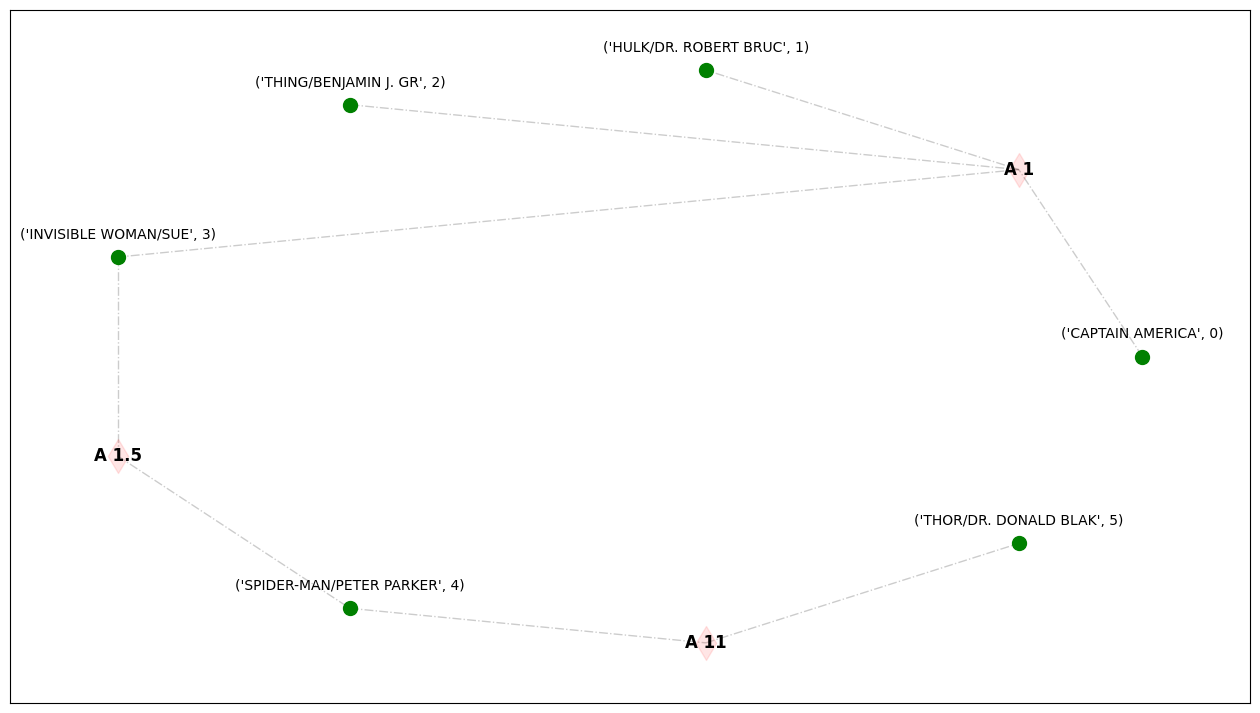

In [198]:
f.visualization()